In [1]:
#import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import metric_dreem
import utils 
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import pickle
from sklearn.model_selection import GridSearchCV

In [2]:
#import data 
data_x_train = h5py.File('../data/X_train.h5')
data_x_test = h5py.File('../data/X_test.h5')
data_x_train['data'].shape, data_x_test['data'].shape
mask_y_train = np.array(pd.read_csv('../data/y_train.csv'))



In [3]:
#preprocess data 
# create sub-sampled dataset
n_samples = 4400
n_subjects = 22
rate = 100

means_data = utils.subsampling_data(data_x_train,rate)
vars_data = utils.subsampling_data_var(data_x_train, rate)

utils.normalization(means_data)
utils.normalization(vars_data)
means_data.shape, vars_data.shape

features = np.zeros((n_samples*90, 2*8))
for k in range(8):
    features[:,k] = means_data[:,k].reshape(-1) 
    features[:,8+k] = vars_data[:,k].reshape(-1)

targets = mask_y_train[:,1:].reshape(-1)
print(features.shape, targets.shape)

positives = []
negatives = []
for k in range(len(targets)):
    if targets[k]:
        positives.append(features[k])
    else:
        negatives.append(features[k])
positives = np.array(positives)
negatives = np.array(negatives)
positives.shape, negatives.shape





(396000, 16) (396000,)


((27214, 16), (368786, 16))

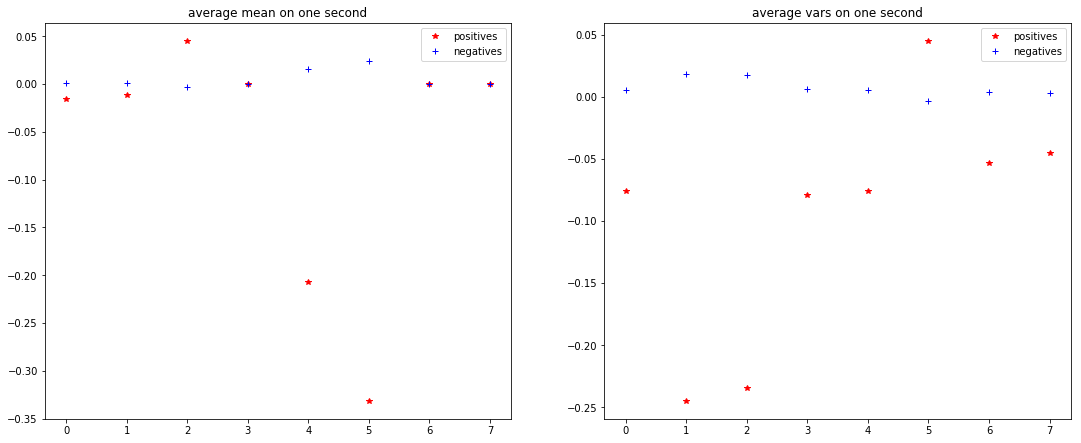

In [4]:
plt.subplot(121)
plt.plot(positives[:,:8].mean(axis=0), '*r', label = 'positives')
plt.plot(negatives[:,:8].mean(axis=0), '+b', label = 'negatives')
plt.legend()
plt.title("average mean on one second")
plt.subplot(122)
plt.plot(positives[:,8:].mean(axis=0), '*r', label = 'positives')
plt.plot(negatives[:,8:].mean(axis=0), '+b', label = 'negatives')
plt.legend()
plt.title("average vars on one second")
plt.subplots_adjust(top=1.5, right=2.5)

In [5]:
training_size = 200*17*90

In [6]:
training_features, training_targets = utils.eliminating_zeros(features[:training_size], targets[:training_size], 0.5)

In [7]:
targets.mean(), training_targets.mean()

(0.06872222222222223, 0.13269740651571024)

In [8]:
print(training_features.shape, training_targets.shape)
X_train , X_test , y_train, y_test = train_test_split(training_features, training_targets, random_state=0)

(164065, 16) (164065,)


In [9]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100]},
                    {'kernel': ['rbf'], 'C': [1, 10, 100]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        SVC(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(X_train, y_train)
    filename = 'finalized_model_'+score+'.sav'
    pickle.dump(model, open(filename, 'wb'))
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()



# Tuning hyper-parameters for precision



/usr/lib/python3/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


KeyboardInterrupt: 

In [9]:
test_features, test_targets = utils.eliminating_zeros(features[training_size:], targets[training_size:], 0.5)
training_features, training_targets = utils.eliminating_zeros(features[:training_size], targets[:training_size], 0.25)
test_features, test_targets = test_features[:test_features.shape[0]-test_features.shape[0]%90], test_targets[:test_targets.shape[0]-test_targets.shape[0]%90]

In [10]:
print(training_features.shape, training_targets.shape)
print(test_features.shape, test_targets.shape)

(92760, 16) (92760,)
(47790, 16) (47790,)


In [11]:
X_train_zero , X_test_zero , y_train_zero, y_test_zero = training_features,  test_features, training_targets, test_targets

In [ ]:
#train model, il est cependant conseillé d'executer la cellule suivante à la place
rbf_svc_z = SVC(kernel='rbf', C=100)
rbf_svc_z.fit(X_train_zero, y_train_zero)
filename = 'svc_rbf_zerorate_model.sav'
joblib.dump(rbf_svc_z, filename)

In [12]:
rbf_svc_z = joblib.load(r'svc_rbf_zerorate_model.sav') 
#svc = joblib.load(r'svc_rbf_feature_model.sav'), modèle précendnant sans sub-sampling, résultats pires 

ModuleNotFoundError: No module named 'sklearn.svm._classes'

In [ ]:
mean_acc = rbf_svc_z.score(X_test_zero, y_test_zero)
print(mean_acc)

In [ ]:
print(np.mean(y_test_zero))

In [ ]:
### try on test data
test_sampled_data = utils.subsampling_data(data_x_test, rate, special=1)
test_sampled_data = utils.normalization(test_sampled_data)

In [ ]:
predictions = rbf_svc_z.predict(X_test_zero).reshape(-1,90)


In [ ]:
threshold_grid_search = np.zeros(100)
for k in range(100):
    try:
        threshold_grid_search[k] = metric_dreem.dreem_sleep_apnea_custom_metric(predictions>k/100, y_test_zero.reshape(-1,90))
    except:
        threshold_grid_search[k] = -0.1
plt.plot(threshold_grid_search)

In [ ]:
results = metric_dreem.dreem_sleep_apnea_custom_metric(utils.low_band_filter(predictions>0.025).reshape(5,-1), 
                                            y_test_zero.reshape(5,-1))
best_results = np.load(r"best_results_svm.npy")
print('results: {:.4f} , best results: {:.4f}'.format(results, best_results))

In [ ]:
# only if results are good
if results>=best_results:
    np.save('best_results_svm.npy', np.array(results) )
    filename = 'svc_rbf_zerorate_model.sav'
    joblib.dump(rbf_svc_z, filename)
    print('new model saved!')
'done'